Hyperparameter Tuning : the process of finding the best set of hyperparameters (parameters that are not learned during training, like learning rate, batch size, etc.) to optimize a model's performance.

Going to tune following parameters using optuna:
1. No of hidden layers
2. Neurons per layer 
3. No of epochs
4. Optimizer
5. Learning rate
6. Batch size
7. Dropout rate 
8. Weight decay (Lambda)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [ ]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
df = pd.read_csv('/content/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.shape

(60000, 785)

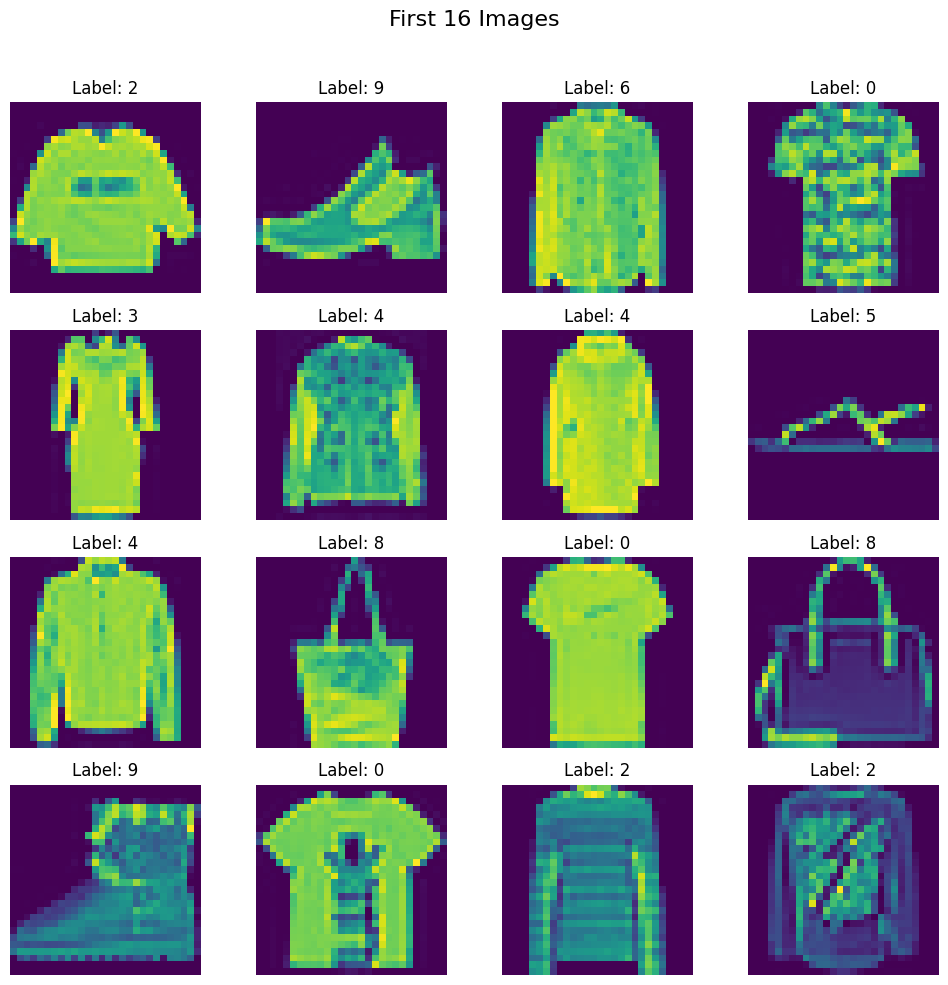

In [ ]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [ ]:
# train test split

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train = X_train/255.0
X_test = X_test/255.0

In [ ]:
class CustomDataset(Dataset):

  def __init__(self, features, labels):

    # Convert to PyTorch tensors
    self.features = torch.tensor(features, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [ ]:
train_dataset = CustomDataset(X_train, y_train)

In [ ]:
test_dataset = CustomDataset(X_test, y_test)

In [ ]:
len(train_loader)

1500

In [ ]:
class MyNN(nn.Module):

  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):

    super().__init__()

    layers = []

    for i in range(num_hidden_layers):

      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim = neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer, output_dim))

    self.model = nn.Sequential(*layers)

  def forward(self, x):

    return self.model(x)

WorkFlow: 
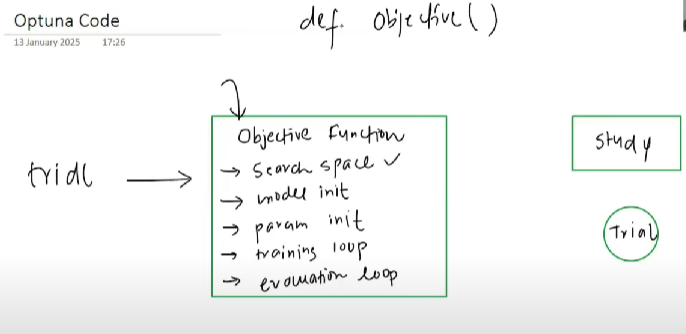

In [ ]:
# objective function
def objective(trial):

  # next hyperparameter values from the search space
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)  # from 8,16,24 .......
  epochs = trial.suggest_int("epochs", 10, 50, step=10)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
  batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
  optimizer_name = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
  weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

  # model init
  input_dim = 784
  output_dim = 10

  model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model.to(device)

  # optimizer selection
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

  if optimizer_name == 'Adam':
    optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == 'SGD':
    optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # training loop

  for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      # forward pass
      outputs = model(batch_features)

      # calculate loss
      loss = criterion(outputs, batch_labels)

      # back pass
      optimizer.zero_grad()
      loss.backward()

      # update grads
      optimizer.step()


  # evaluation
  model.eval()
  # evaluation on test data
  total = 0
  correct = 0

  with torch.no_grad():

    for batch_features, batch_labels in test_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      outputs = model(batch_features)

      _, predicted = torch.max(outputs, 1)

      total = total + batch_labels.shape[0]

      correct = correct + (predicted == batch_labels).sum().item()

    accuracy = correct/total

  return accuracy

In [ ]:
# !pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.5 MB/s eta 0:00:00


In [ ]:
import optuna

study = optuna.create_study(direction='maximize')  # bcz we want to maximize the accuracy  

[I 2025-01-13 13:26:16,358] A new study created in memory with name: no-name-ee425324-3634-4341-8ab9-acbab0183b39


In [ ]:
study.optimize(objective, n_trials=10)

[I 2025-01-13 13:26:56,273] Trial 0 finished with value: 0.739 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 8, 'epochs': 30, 'learning_rate': 2.8745852745500735e-05, 'dropout_rate': 0.2, 'batch_size': 128, 'optimizer': 'Adam', 'weight_decay': 4.287383191785143e-05}. Best is trial 0 with value: 0.739.
[I 2025-01-13 13:27:25,444] Trial 1 finished with value: 0.8908333333333334 and parameters: {'num_hidden_layers': 4, 'neurons_per_layer': 88, 'epochs': 20, 'learning_rate': 0.000300318300747871, 'dropout_rate': 0.2, 'batch_size': 128, 'optimizer': 'RMSprop', 'weight_decay': 0.0004539602814543209}. Best is trial 1 with value: 0.8908333333333334.
[I 2025-01-13 13:29:42,814] Trial 2 finished with value: 0.8688333333333333 and parameters: {'num_hidden_layers': 4, 'neurons_per_layer': 48, 'epochs': 30, 'learning_rate': 0.03372712678048189, 'dropout_rate': 0.30000000000000004, 'batch_size': 32, 'optimizer': 'RMSprop', 'weight_decay': 4.6127276184846335e-05}. Best is trial 1 with

In [ ]:
study.best_value

0.8908333333333334

In [ ]:
study.best_params

{'num_hidden_layers': 4,
 'neurons_per_layer': 88,
 'epochs': 20,
 'learning_rate': 0.000300318300747871,
 'dropout_rate': 0.2,
 'batch_size': 128,
 'optimizer': 'RMSprop',
 'weight_decay': 0.0004539602814543209}

In [ ]:
# To get better results :  we can increase the number of trials and range of hyperparameters  